1. data cleaning

In [233]:
# importing data and libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv')

In [234]:
# removing duplicates
df = df.drop_duplicates()
print(df.shape)

(444762, 41)


In [235]:
# creating an Accurate Calculated BMI column
df['CalculatedBMI'] = df['WeightInKilograms'] / (df['HeightInMeters'] ** 2)

In [236]:
# logic checks

invalid_bmi = df[(df['BMI'] < 10) | (df['BMI'] > 80)]  # BMI typically ranges from 10 to 50
invalid_sleep = df[(df['SleepHours'] < 0) | (df['SleepHours'] > 24)]  # Sleep hours must be 0-24
suspicious_sleep_values = df[(df['SleepHours'] < 3) | (df['SleepHours'] > 22)] #maybe cap as outliers (?)


print(f"Invalid BMI entries: {len(invalid_bmi)}")
print(f"Invalid Sleep Hours entries: {len(invalid_sleep)}")
print(f"Suspicious sleep hours to check again: {len(suspicious_sleep_values)}")

# 1.4.1 ff AgeCategory is '65 or older', they should likely report having at least one of the following: 
#   heart attack, stroke, or diabetes
age_category_inconsistencies = df[
    (df['AgeCategory'] == '65 or older') &
    ~(df[['HadHeartAttack', 'HadStroke', 'HadDiabetes']].any(axis=1))
]
print(f"Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): {len(age_category_inconsistencies)}")

# 1.4.2 if SmokerStatus is 'Yes', they should likely report at least one of the following:
#   heart attack, COPD, asthma, stroke
smoker_inconsistencies = df[
    (df['SmokerStatus'] == 'Yes') &
    ~(df[['HadHeartAttack', 'HadCOPD', 'HadAsthma', 'HadStroke']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in SmokerStatus (smoker but no major related health conditions): {len(smoker_inconsistencies)}")

# 1.4.3 if DifficultyWalking is True, then at least one of the following should also be True:
#   difficulty dressing and bathing, difficulty running errands
walking_inconsistencies = df[
    (df['DifficultyWalking'] == True) &
    ~(df[['DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): {len(walking_inconsistencies)}")

# 1.4.4 if HadCOPD is True, then at least one of the following should also be True:
# difficulty walking, difficulty dressing and bathing, difficulty running errands
copd_inconsistencies = df[
    (df['HadCOPD'] == True) &
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in HadCOPD (COPD but no difficulties with daily activities): {len(copd_inconsistencies)}")

# 1.4.5 if HadHeartAttack is True, then at least one of the following should be True:
# stroke, angina, chest scan
heart_attack_inconsistencies = df[
    (df['HadHeartAttack'] == True) &
    ~(df[['HadStroke', 'HadAngina', 'ChestScan']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in HadHeartAttack (Heart Attack but no related conditions reported): {len(heart_attack_inconsistencies)}")

# 1.4.6 if SleepHours is less than 4 or more than 12, we expect at least one of the health conditions to be True:
# depressive disorder, heart attack, angina, stroke, skin cancer, asthma, COPD, kidney disease, arthritis, diabetes, difficulty concentrating, high risk last year
sleep_hours_inconsistencies = df[
    ((df['SleepHours'] < 5) | (df['SleepHours'] > 12)) &
    ~(df[['HadDepressiveDisorder', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadSkinCancer', 'HadAsthma', 'HadCOPD', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DifficultyConcentrating', 'HighRiskLastYear']].any(axis=1))  # None of these is True
]
print(f"Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): {len(sleep_hours_inconsistencies)}")

# 1.4.7 if PhysicalHealthDays is 0, they should not report significant limitations in daily activities
physical_health_inconsistencies = df[
    (df['PhysicalHealthDays'] == 0) &
    ~(df[['DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands']].any(axis=1))]  # No difficulty reported
print(f"Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): {len(physical_health_inconsistencies)}")



Invalid BMI entries: 0
Invalid Sleep Hours entries: 0
Suspicious sleep hours to check again: 0
Number of logical inconsistencies in AgeCategory (age 65+ but no major health conditions): 0
Number of logical inconsistencies in SmokerStatus (smoker but no major related health conditions): 0
Number of logical inconsistencies in DifficultyWalking (difficulty walking but no related difficulties): 0
Number of logical inconsistencies in HadCOPD (COPD but no difficulties with daily activities): 0
Number of logical inconsistencies in HadHeartAttack (Heart Attack but no related conditions reported): 0
Number of logical inconsistencies in SleepHours (abnormal sleep but no related health conditions): 0
Number of logical inconsistencies in PhysicalHealthDays (0 health days but activity limitations): 0


In [237]:
# filling in missing values for numerical + object columns
df.fillna({col: df[col].median() for col in df.select_dtypes('float64')}, inplace=True)
df.fillna({col: df[col].mode().iloc[0] for col in df.select_dtypes('object')}, inplace=True)


print(df.isnull().sum()) #to check


State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

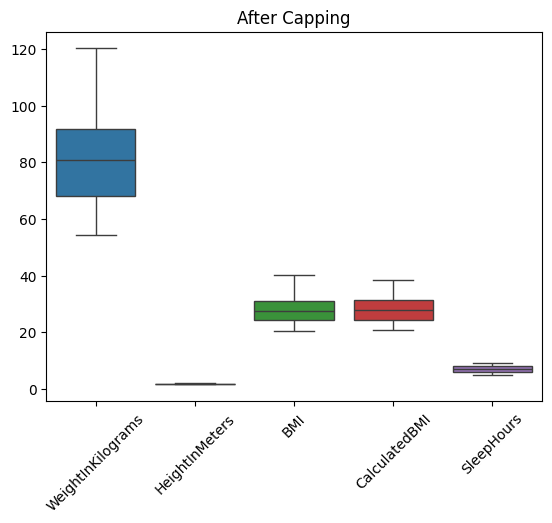

In [238]:
# capping outliers
def cap_outliers(df, columns, lower_percentile=0.05, upper_percentile=0.95):
    for column in columns:
        lower_bound = df[column].quantile(lower_percentile)
        upper_bound = df[column].quantile(upper_percentile)
       
        # Apply capping
        df[column] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound))
   
    return df


# list of columns to cap
columns_to_cap = ['WeightInKilograms', 'HeightInMeters', 'BMI', 'CalculatedBMI', 'SleepHours']


# applying the capping
df_cleaned = cap_outliers(df, columns_to_cap)


# verification of capping
sns.boxplot(data=df[columns_to_cap])
plt.title("After Capping")
plt.xticks(rotation=45)
plt.show()


In [239]:
# cleaning and standardizing text data
for col in df.select_dtypes(include=['category', 'object']).columns:
    df[col] = df[col].str.strip().str.lower()

In [240]:
dataframe = df.drop_duplicates()


In [241]:
dataframe.to_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv', index=False)

2. preparing data for the model

In [242]:
dataframe = pd.read_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv')

In [243]:
# converting string columns to numeric
def string_to_numeric(entry):
    if entry == 'yes':
        return 1
    elif entry == 'no':
        return 0
    elif entry == 'no, pre-diabetes or borderline diabetes':
        return 0.5

dataframe = dataframe.applymap(lambda x: string_to_numeric(x) if x in ['yes', 'no', 'no, pre-diabetes or borderline diabetes'] else x)

dataframe.to_csv('Heart_cleaned.csv', index=False)
# see list below for health/lifestyle risk factors ranked from most to least disruptive to daily life

/var/folders/qn/4dpq089x26d0h5p0v709glyw0000gn/T/ipykernel_28220/2215751205.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataframe = dataframe.applymap(lambda x: string_to_numeric(x) if x in ['yes', 'no', 'no, pre-diabetes or borderline diabetes'] else x)


from most to least disruptive:
* stroke = 10 pts
* heart attack = 9.5 pts
* COPD = 9 pts
* depressive disorder = 8.5 pts
* blind / vision difficulty = 8.5 pts
* difficulty dressing and bathing = 8.5 pts
* angina = 8 pts
* arthritis = 7.5 pts
* kidney disease = 7.5 pts
* difficulty concentrating = 7 pts
* diabetes = 7 pts
* asthma = 6.5 pts
* difficulty running errands = 6 pts
* deaf / hard of hearing = 6 pts
* skin cancer = 5.5 pts
* calculated bmi < 18.5 - 5 pts
* calculated bmi > 24.9 = 4.5 pts 
(bmi normal range is 18.5-24.9)
* smoker status: current smoker - now smokes every day = 4.5 pts
* e-cigarette usage - use them every day = 4 pts
* smoker status: current smoker - now smokes some days = 3.5 pts
* e-cigarette usage: use them some days - 3 pts
* smoker status: former smoker = 2.5 pts
* e-cigarette usage: not at all (right now) = 2 pts
* smoker status: never smoked = 2 pts
* e-cigarette usage: never used e-cigarettes in my entire life = 2 pts
* alcohol drinkers = 2 pts
* sleep hours < 7 hours = 1.5 pts

In [244]:
# initialising the total risk score column
dataframe['RiskScore'] = 0

In [245]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (10 * dataframe['HadStroke'])

In [246]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (9.5 * dataframe['HadHeartAttack'])

In [247]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (9 * dataframe['HadCOPD'])

In [248]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (8.5 * dataframe['HadDepressiveDisorder'])

In [249]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (8.5 * dataframe['BlindOrVisionDifficulty'])

In [250]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (8.5 * dataframe['DifficultyDressingBathing'])

In [251]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (8 * dataframe['HadAngina'])

In [252]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (7.5 * dataframe['HadArthritis'])

In [253]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (7.5 * dataframe['HadKidneyDisease'])

In [254]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (7 * dataframe['DifficultyConcentrating'])

In [257]:
dataframe.loc[dataframe['HadDiabetes'] == 0, 'RiskScore'] = dataframe['RiskScore'] + (7 * 0)
dataframe.loc[dataframe['HadDiabetes'] == 0.5, 'RiskScore'] = dataframe['RiskScore'] + (7 * 0.5)
dataframe.loc[dataframe['HadDiabetes'] == 1, 'RiskScore'] = dataframe['RiskScore'] + (7 * 1)

In [258]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (6.5 * dataframe['HadAsthma'])

In [259]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (6 * dataframe['DifficultyErrands'])

In [260]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (6 * dataframe['DeafOrHardOfHearing'])

In [261]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (5.5 * dataframe['HadSkinCancer'])

In [262]:
dataframe.loc[dataframe['CalculatedBMI'] < 18.5, 'RiskScore'] = dataframe['RiskScore'] + (5 * dataframe['CalculatedBMI'])
dataframe.loc[dataframe['CalculatedBMI'] > 24.9, 'RiskScore'] = dataframe['RiskScore'] + (4.5 * dataframe['CalculatedBMI'])

In [263]:
dataframe.loc[dataframe['SmokerStatus'] == 'never smoked', 'RiskScore'] = dataframe['RiskScore'] + 2
dataframe.loc[dataframe['SmokerStatus'] == 'former smoker', 'RiskScore'] = dataframe['RiskScore'] + 2.5
dataframe.loc[dataframe['SmokerStatus'] == 'current smoker - now smokes some days', 'RiskScore'] = dataframe['RiskScore'] + 3.5
dataframe.loc[dataframe['SmokerStatus'] == 'current smoker - now smokes every day', 'RiskScore'] = dataframe['RiskScore'] + 4.5

In [264]:
dataframe.loc[dataframe['ECigaretteUsage'] == 'never used e-cigarettes in my entire life', 'RiskScore'] = dataframe['RiskScore'] + 2
dataframe.loc[dataframe['ECigaretteUsage'] == 'not at all (right now)', 'RiskScore'] = dataframe['RiskScore'] + 2
dataframe.loc[dataframe['ECigaretteUsage'] == 'use them some days', 'RiskScore'] = dataframe['RiskScore'] + 3
dataframe.loc[dataframe['ECigaretteUsage'] == 'use them every day', 'RiskScore'] = dataframe['RiskScore'] + 4

In [265]:
dataframe['RiskScore'] = dataframe['RiskScore'] + (2 * dataframe['AlcoholDrinkers'])

In [266]:
dataframe.loc[dataframe['SleepHours'] < 7.0, 'RiskScore'] = dataframe['RiskScore'] + 1.5

In [267]:
dataframe.to_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv', index=False)

3. coding the unsupervised learning model (K-Means)

In [268]:
from sklearn.cluster import KMeans

In [269]:
dataframe['TrueHealth'] = 'default_value'
dataframe.to_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv', index=False)

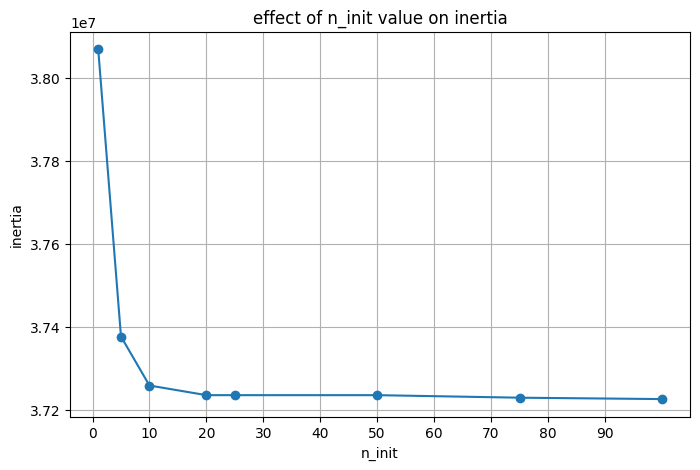

In [270]:
data = dataframe[['RiskScore']]

# testing different 'n_init' values
n_init_values = [1, 5, 10, 20, 25, 50, 75, 100]
inertia_values = []

for n in n_init_values:
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=n).fit(data)
    inertia_values.append(kmeans.inertia_)

# plotting inertia vs 'n_init' values
plt.figure(figsize=(8,5))
plt.plot(n_init_values, inertia_values, marker='o')
plt.xticks(np.arange(0,100,10))
plt.xlabel("n_init")
plt.ylabel("inertia")
plt.title("effect of n_init value on inertia")
plt.grid(True)
plt.show()

In [271]:
# actually coding the model
column = dataframe['RiskScore']
riskscore_2d = column.values.reshape(-1,1) # changing it to a 2D array

kmeans_minirs = KMeans(n_clusters=5, random_state=42, n_init=10).fit(riskscore_2d)

labels = kmeans_minirs.labels_

centroids = kmeans_minirs.cluster_centers_.flatten()

sorted_labels = np.argsort(centroids)

label_mapping = {original: sorted for sorted, original in enumerate(sorted_labels)}

remapped_labels = [label_mapping[label] for label in labels]

status_mapping = {
    0: "good",
    1: "excellent",
    2: "poor",
    3: "very good",
    4: "fair"
}
health_statuses = [status_mapping[label] for label in labels]

dataframe['TrueHealth'] = health_statuses

print(dataframe[['RiskScore', 'TrueHealth']].head())

print(dataframe['TrueHealth'].value_counts())

df.to_csv('/Users/nikgurunathan/Desktop/Heart_cleaned.csv', index=False)

    RiskScore TrueHealth
0  136.719723       good
1  130.601562       good
2  126.927624       good
3   19.500000  excellent
4    6.000000  excellent
TrueHealth
good         144826
very good    114388
excellent     99040
poor          59909
fair          26599
Name: count, dtype: int64


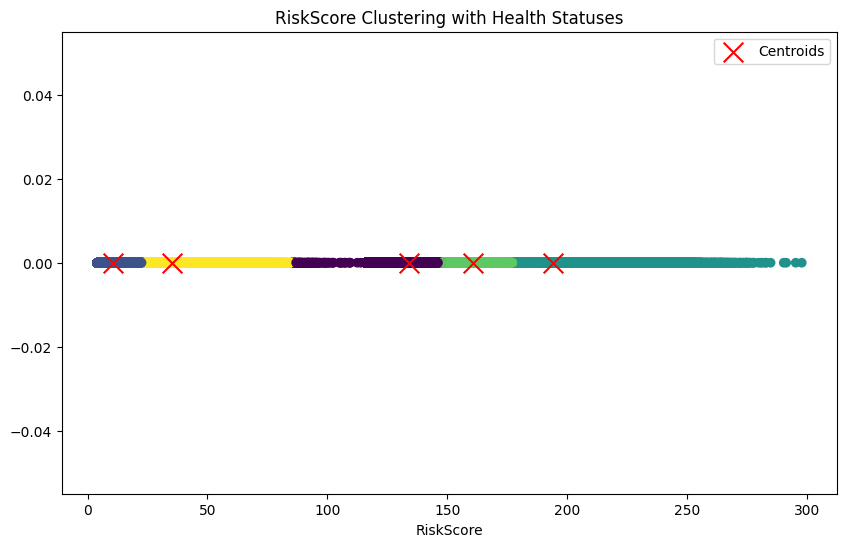

In [272]:
# Plot the RiskScore against the assigned health status
plt.figure(figsize=(10, 6))
plt.scatter(dataframe['RiskScore'], np.zeros_like(dataframe['RiskScore']), c=labels, cmap='viridis', marker='o')

# Add centroids to the plot
centroids = kmeans_minirs.cluster_centers_
plt.scatter(centroids, np.zeros_like(centroids), color='red', marker='x', s=200, label='Centroids')

# Customize the plot
plt.xlabel('RiskScore')
plt.title('RiskScore Clustering with Health Statuses')
plt.legend()
plt.show()


In [273]:
# evaluating the model

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# silhouette_avg = silhouette_score(riskscore_2d, labels) # commented as it takes too long to compute
calinski_harabasz = calinski_harabasz_score(riskscore_2d, labels)
davies_bouldin = davies_bouldin_score(riskscore_2d, labels)

# print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")

Calinski-Harabasz Index: 5709982.535
Davies-Bouldin Index: 0.550


In [274]:
dataframe.to_csv('Heart_cleaned.csv', index=False)